In [21]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from bambi import Prior
from plotnine import (
    aes,
    after_stat,
    geom_density,
    geom_histogram,
    geom_line,
    geom_point,
    geom_smooth,
    ggplot,
    labs,
    stat_function,
)
from scipy import integrate
from scipy.stats import beta, binom, lognorm, norm, uniform

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%load_ext nb_black
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [4]:
data = pyreadr.read_r("data/weather_WU.rda")
weather_WU = data["weather_WU"]

<IPython.core.display.Javascript object>

In [7]:
weather_WU.groupby("location").count()

,mintemp,maxtemp,rainfall,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,...,pressure9am,pressure3pm,temp9am,temp3pm,raintoday,risk_mm,raintomorrow,year,month,day_of_year
location,,,,,,,,,,,,,,,,,,,,,
Uluru,98,100,97,100,100,98,100,100,100,100,...,100,100,100,100,97,98,98,100,100,100
Wollongong,100,100,100,98,98,100,99,100,99,100,...,100,100,100,100,100,99,99,100,100,100


<IPython.core.display.Javascript object>

In [8]:
weather_WU = weather_WU[
    ["location", "windspeed9am", "humidity9am", "pressure9am", "temp9am", "temp3pm"]
]

<IPython.core.display.Javascript object>

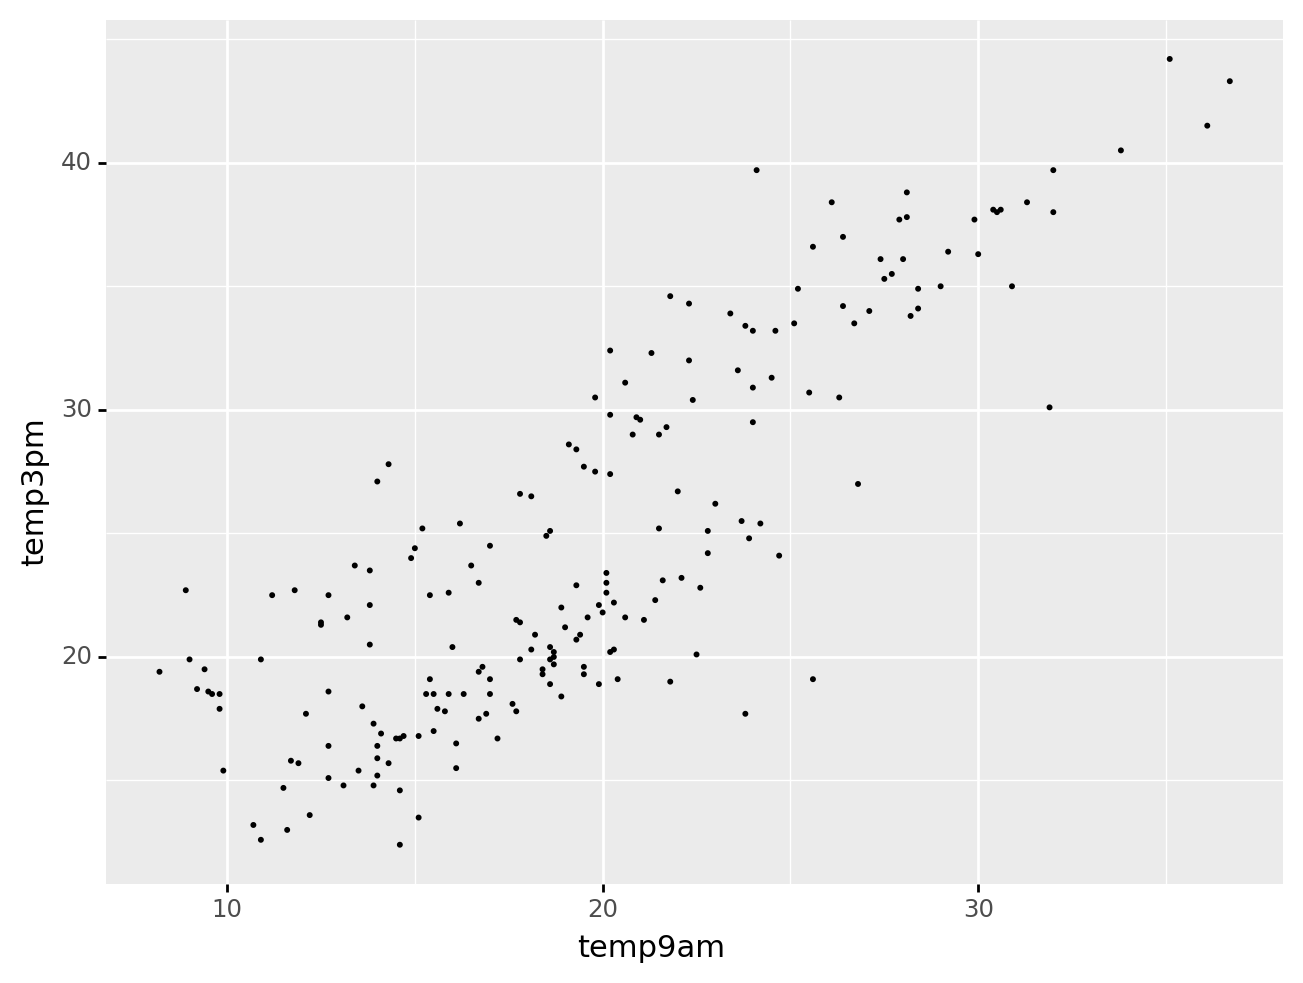

<ggplot: (390040931)>

<IPython.core.display.Javascript object>

In [10]:
(ggplot(weather_WU, aes(x="temp9am", y="temp3pm")) + geom_point(size=0.2))

In [30]:
model = bmb.Model("temp3pm ~ temp9am", weather_WU)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp3pm_sigma, temp9am, Intercept]
INFO:pymc3:NUTS: [temp3pm_sigma, temp9am, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [35]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.201,1.010,2.176,5.976,0.010,0.007,10629.0,5350.0,1.0
temp9am,1.042,0.049,0.949,1.133,0.000,0.000,10678.0,5798.0,1.0
temp3pm_sigma,4.136,0.216,3.747,4.557,0.002,0.002,10416.0,5913.0,1.0


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'temp9am'}>,
        <AxesSubplot:title={'center':'temp9am'}>],
       [<AxesSubplot:title={'center':'temp3pm_sigma'}>,
        <AxesSubplot:title={'center':'temp3pm_sigma'}>]], dtype=object)

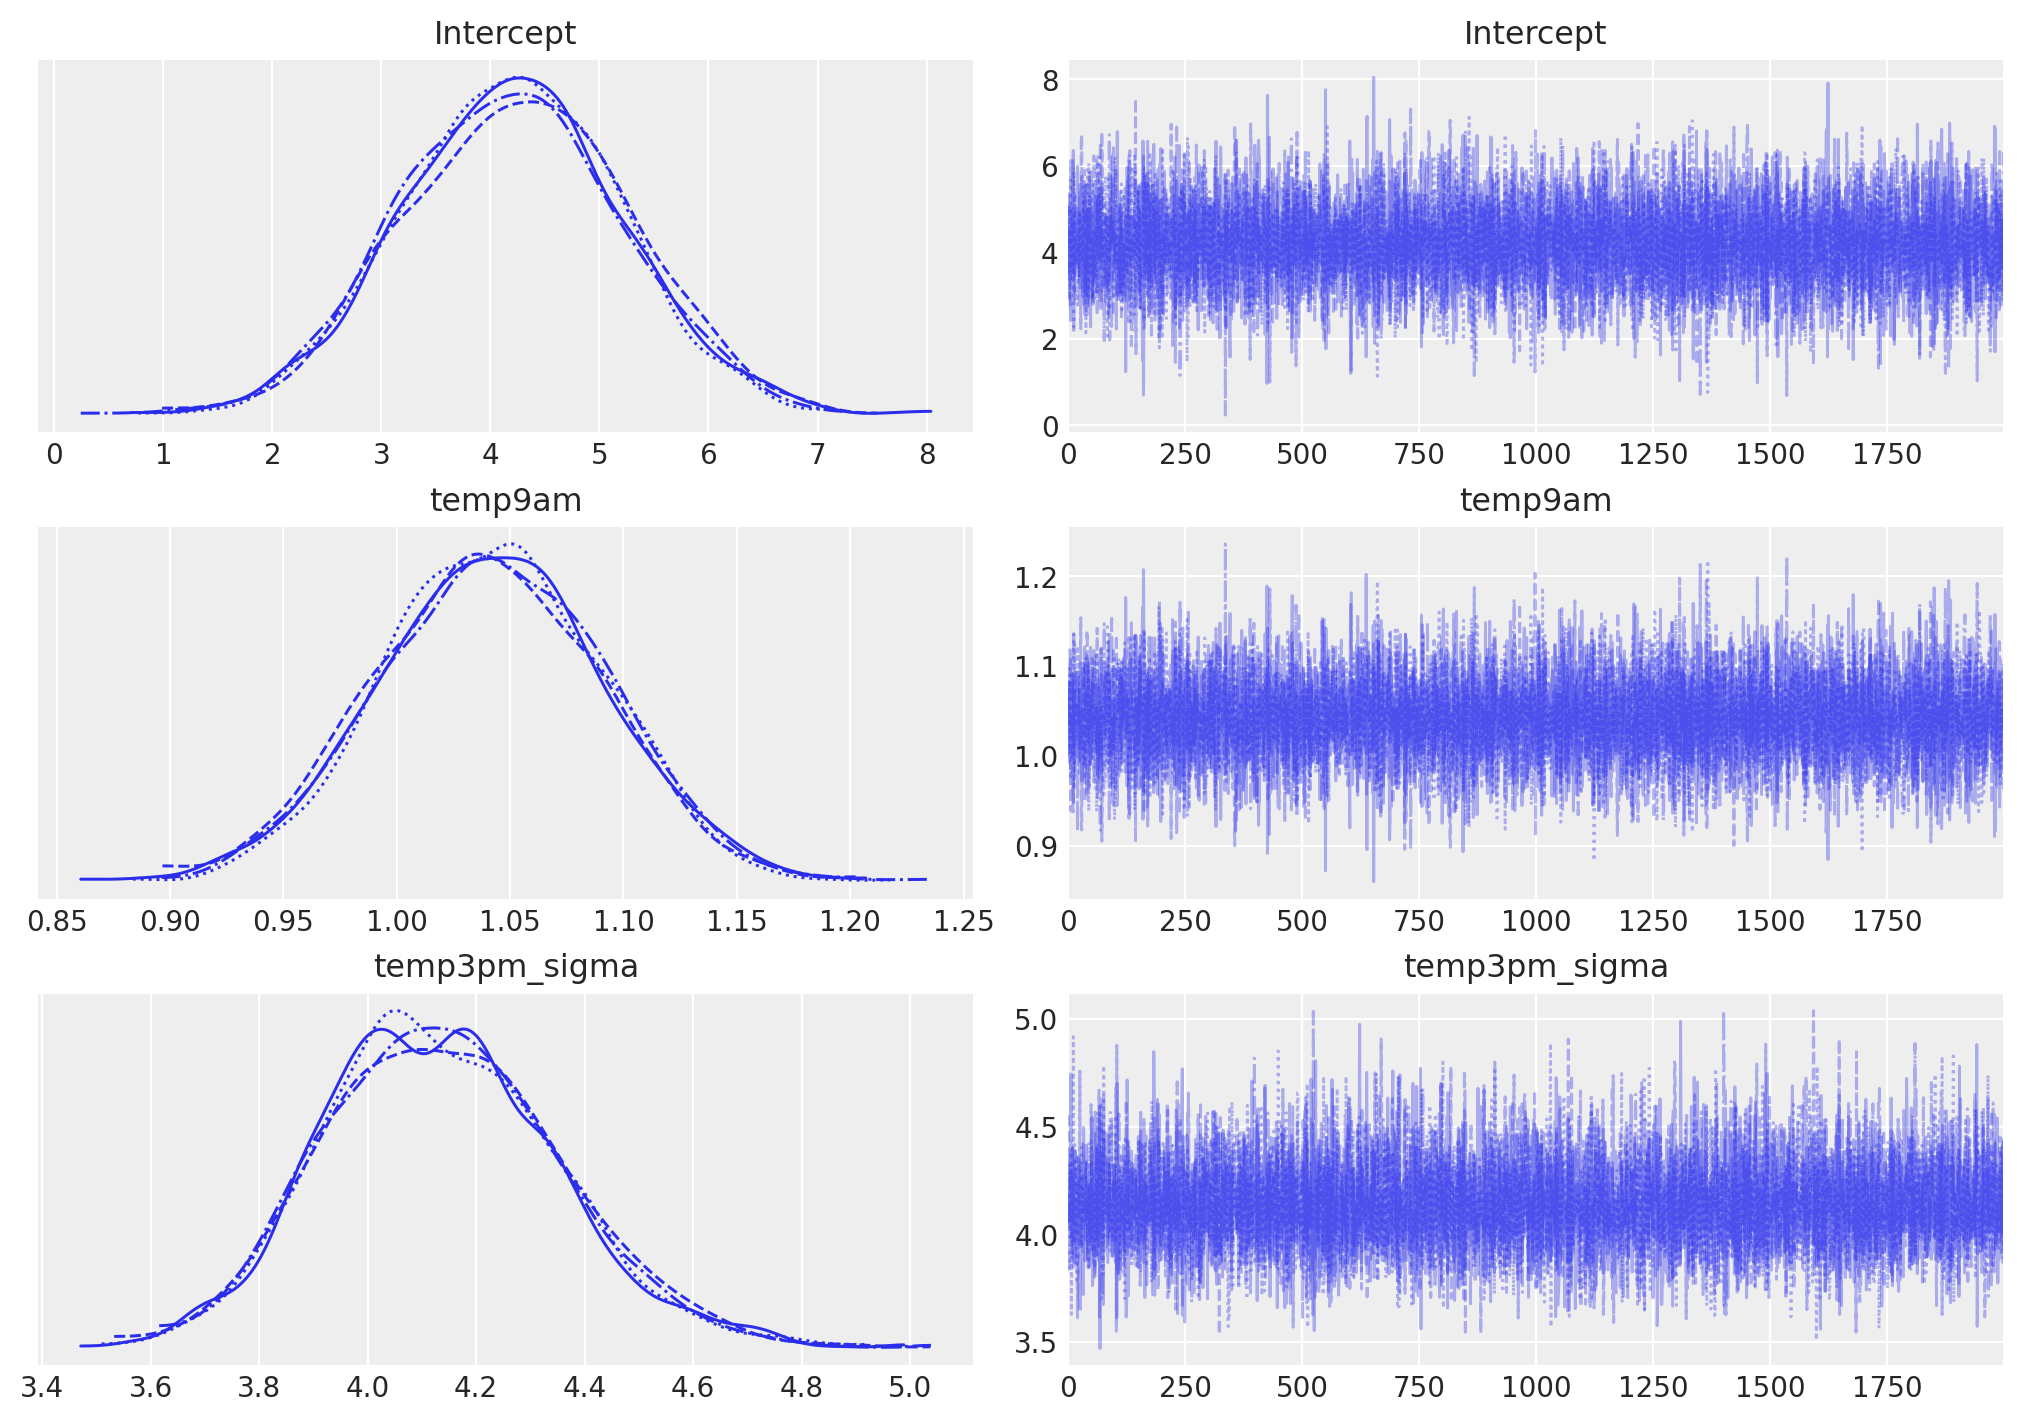

<IPython.core.display.Javascript object>

In [32]:
az.plot_trace(fitted, figsize=(10, 7))

<AxesSubplot:xlabel='temp3pm / temp3pm'>

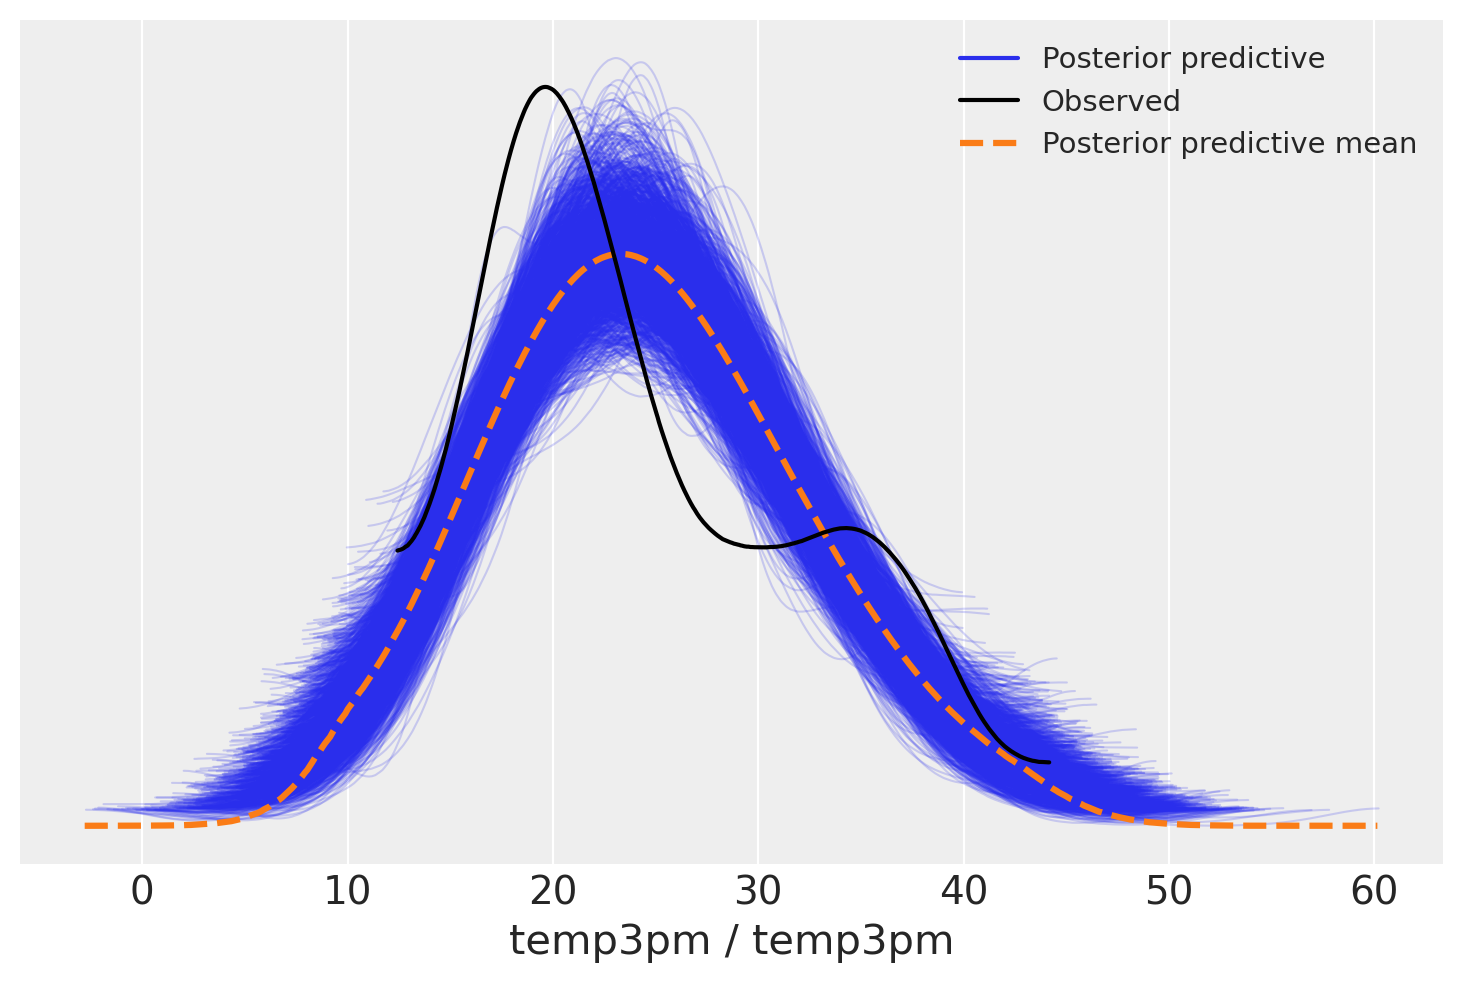

<IPython.core.display.Javascript object>

In [33]:
az.plot_ppc(fitted)

## 11.1 Utilizing a categorical predictor

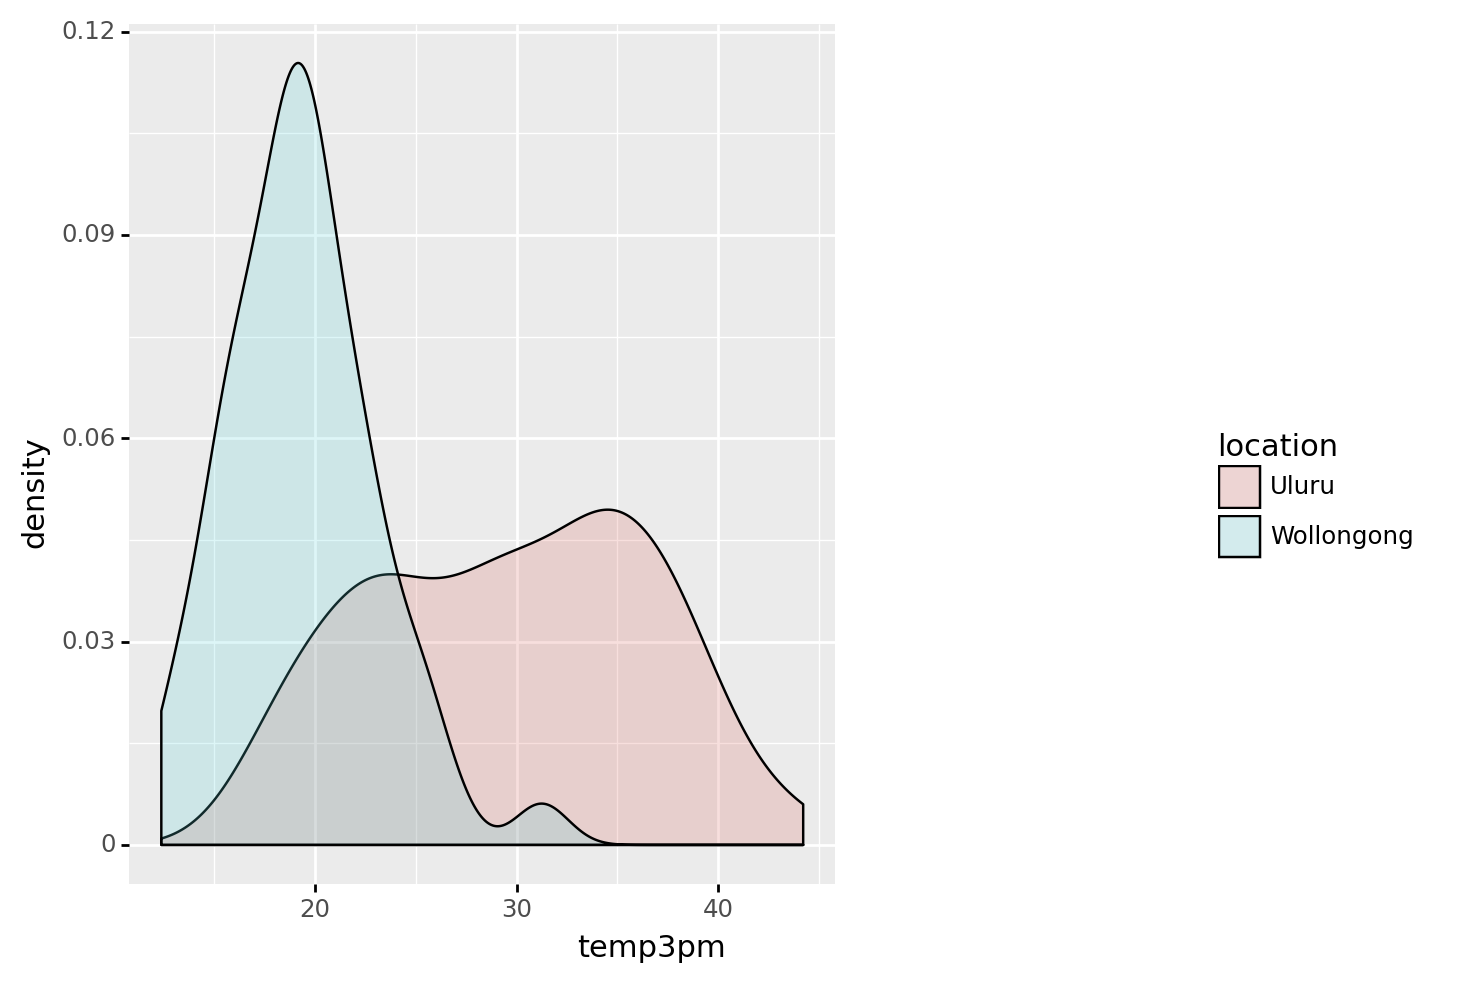

<ggplot: (402988849)>

<IPython.core.display.Javascript object>

In [34]:
(ggplot(weather_WU, aes(x="temp3pm", fill="location")) + geom_density(alpha=0.2))

## 11.1.2 Simulating the posterior

In [36]:
model = bmb.Model("temp3pm ~ location", weather_WU)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp3pm_sigma, location, Intercept]
INFO:pymc3:NUTS: [temp3pm_sigma, location, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

In [37]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,29.727,0.551,28.708,30.737,0.005,0.004,11202.0,5165.0,1.0
location[Wollongong],-10.332,0.779,-11.794,-8.883,0.007,0.005,11278.0,6182.0,1.0
temp3pm_sigma,5.498,0.276,4.982,6.020,0.003,0.002,10553.0,6326.0,1.0


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'location'}>,
        <AxesSubplot:title={'center':'location'}>],
       [<AxesSubplot:title={'center':'temp3pm_sigma'}>,
        <AxesSubplot:title={'center':'temp3pm_sigma'}>]], dtype=object)

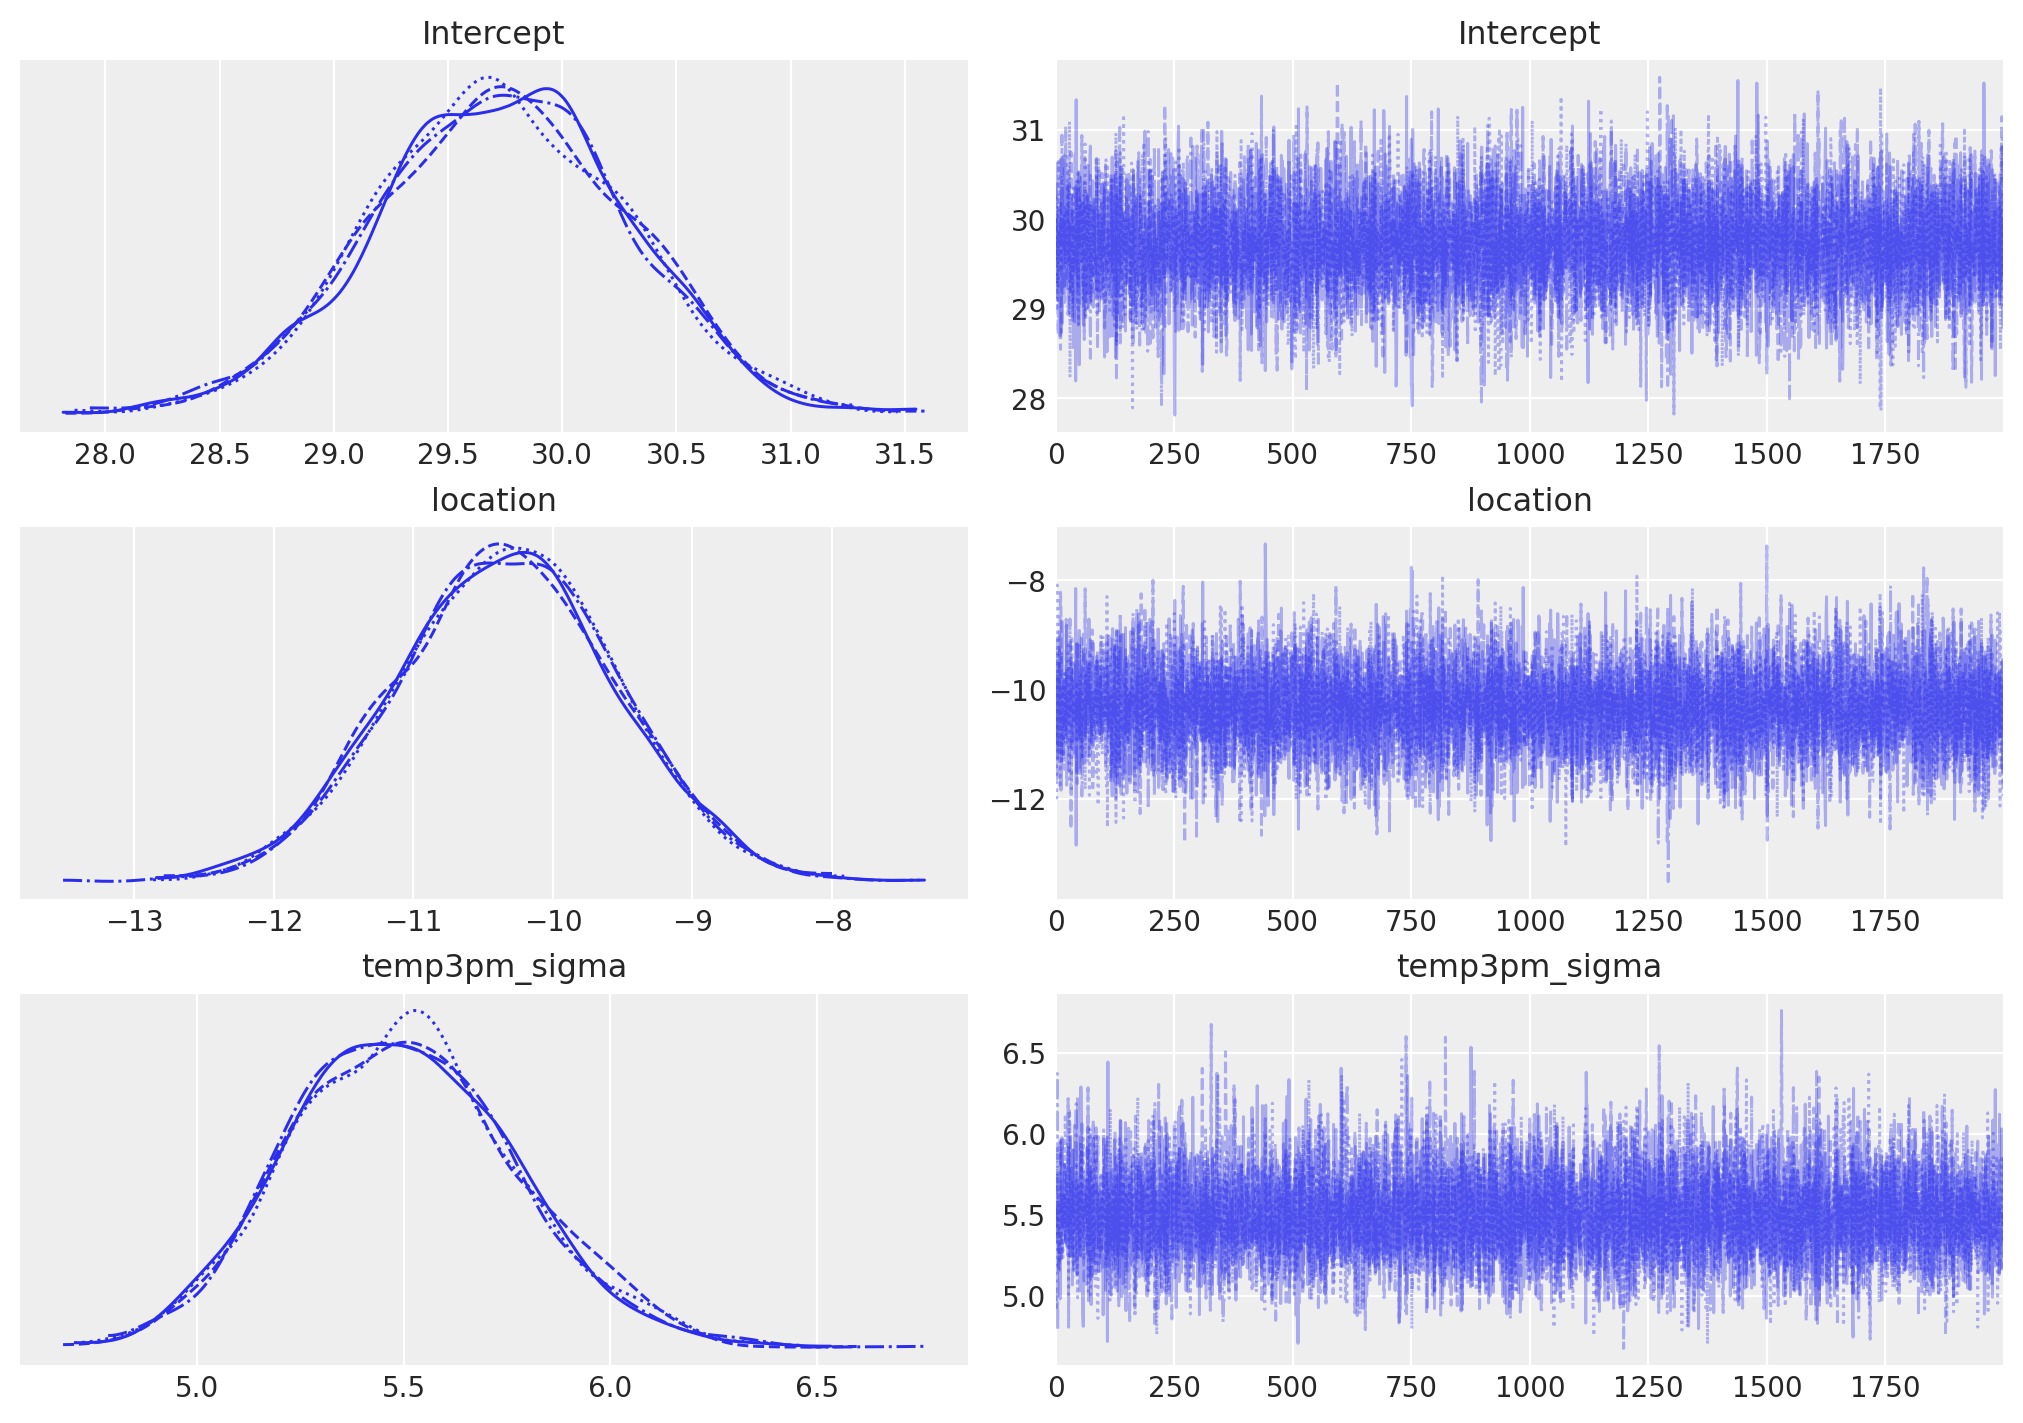

<IPython.core.display.Javascript object>

In [38]:
az.plot_trace(fitted, figsize=(10, 7))

<AxesSubplot:xlabel='temp3pm / temp3pm'>

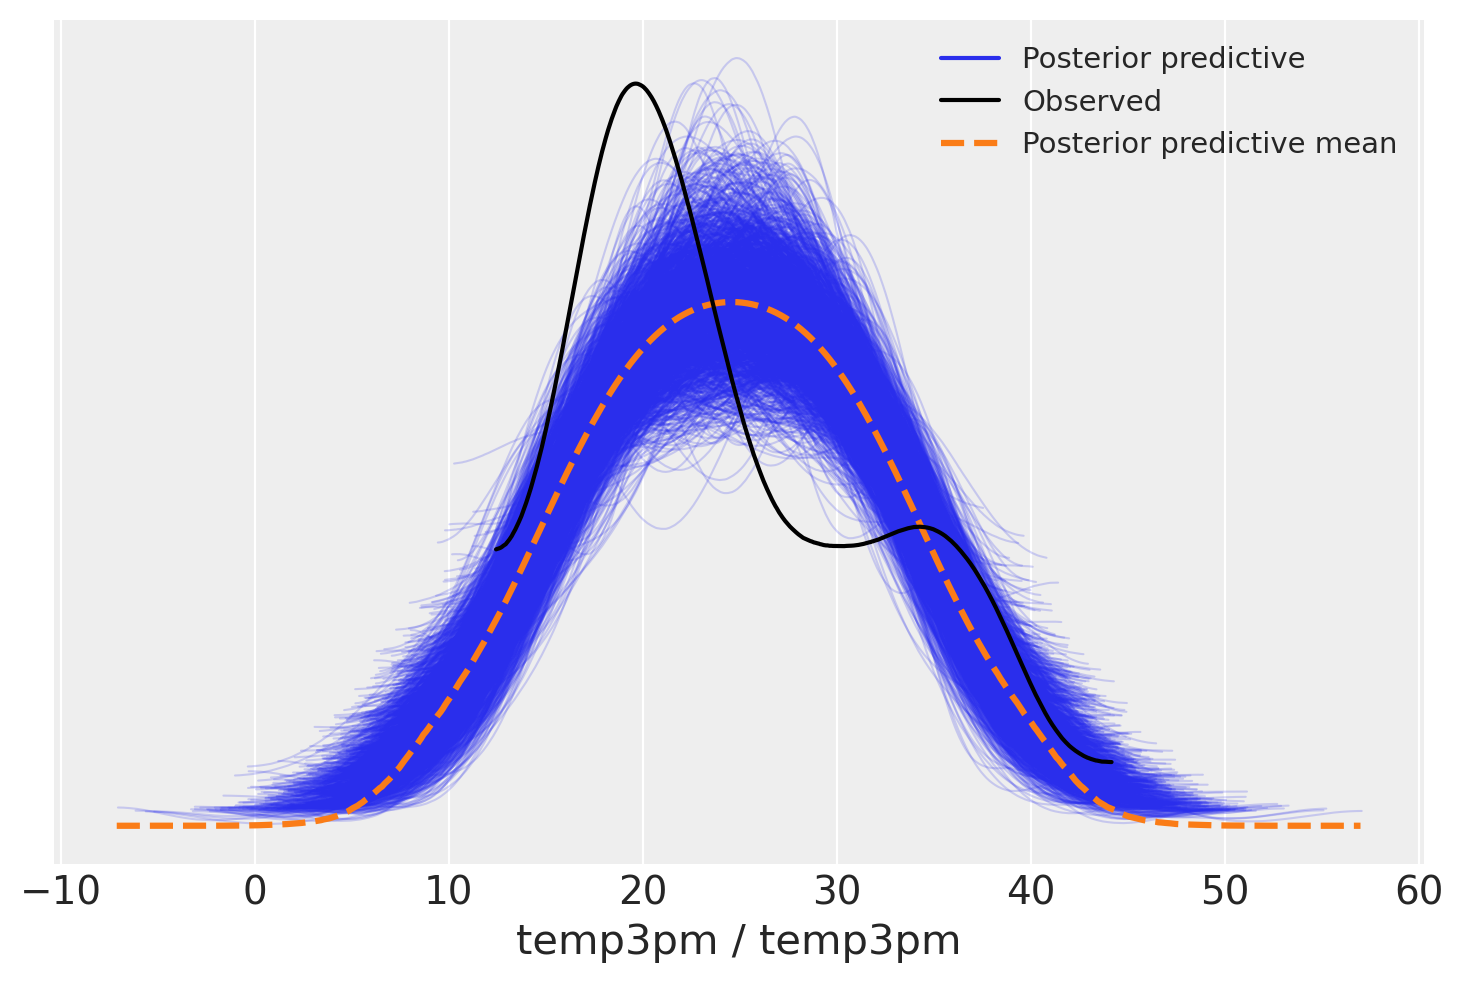

<IPython.core.display.Javascript object>

In [39]:
az.plot_ppc(fitted)

# 11.2 Utilizing two predictors

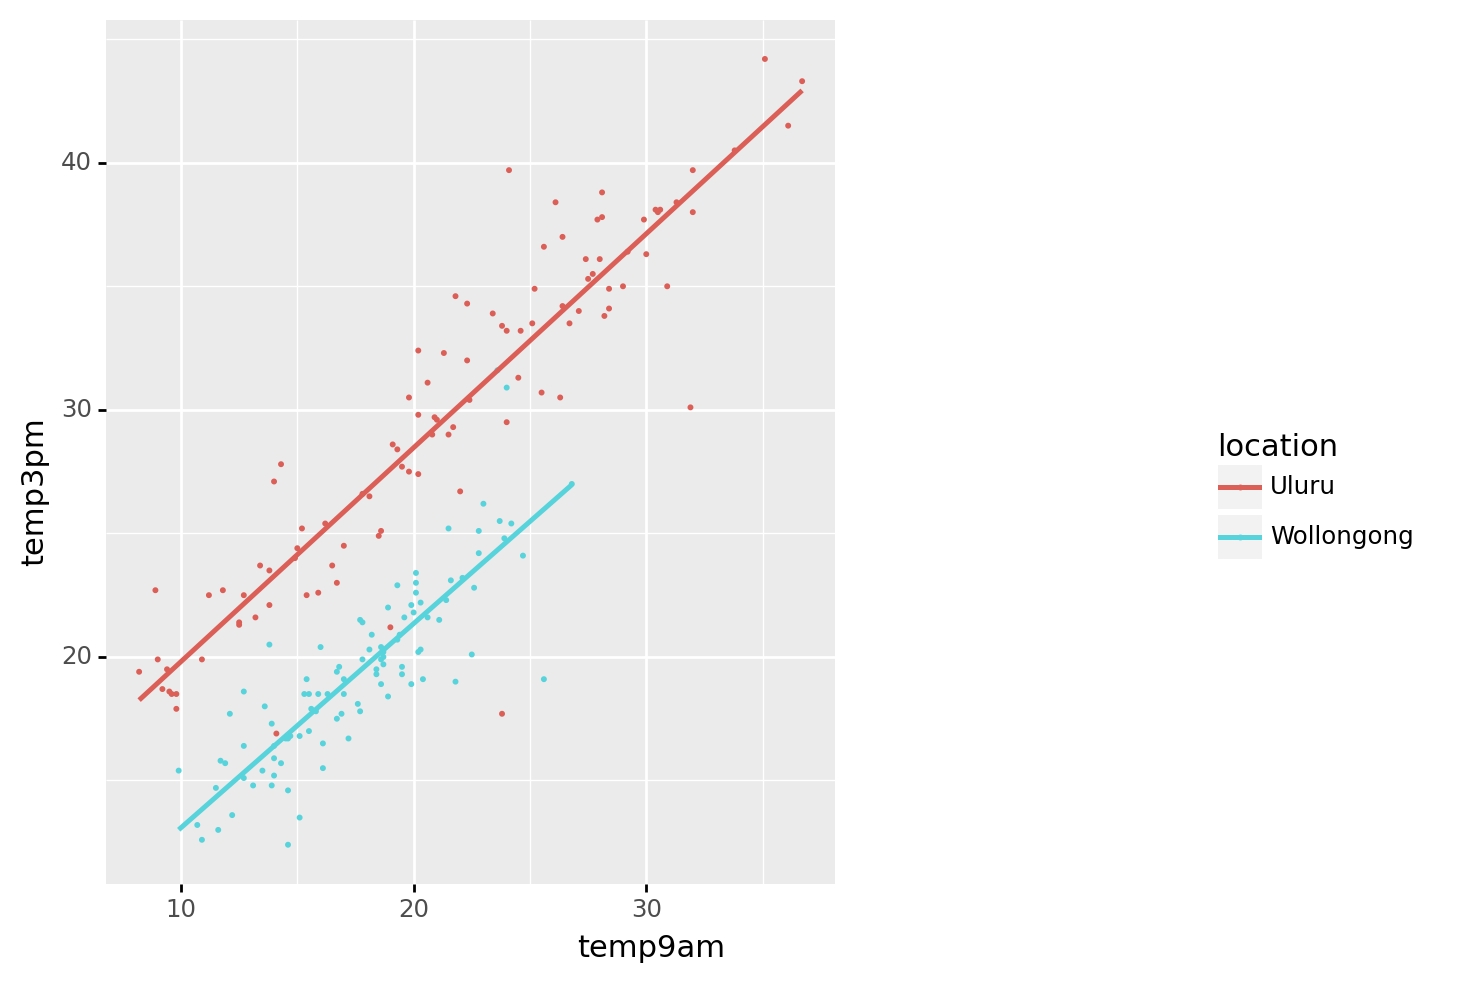

<ggplot: (432631079)>

<IPython.core.display.Javascript object>

In [42]:
(
    ggplot(weather_WU, aes(x="temp9am", y="temp3pm", color="location"))
    + geom_point(size=0.2)
    + geom_smooth(method="lm", se=False)
)

## 11.2.2 Understanding the priors

In [43]:
model = bmb.Model("temp3pm ~ temp9am + location", weather_WU)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp3pm_sigma, location, temp9am, Intercept]
INFO:pymc3:NUTS: [temp3pm_sigma, location, temp9am, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 19 seconds.


<IPython.core.display.Javascript object>

# 11.3 Optional: Utilizing interaction terms

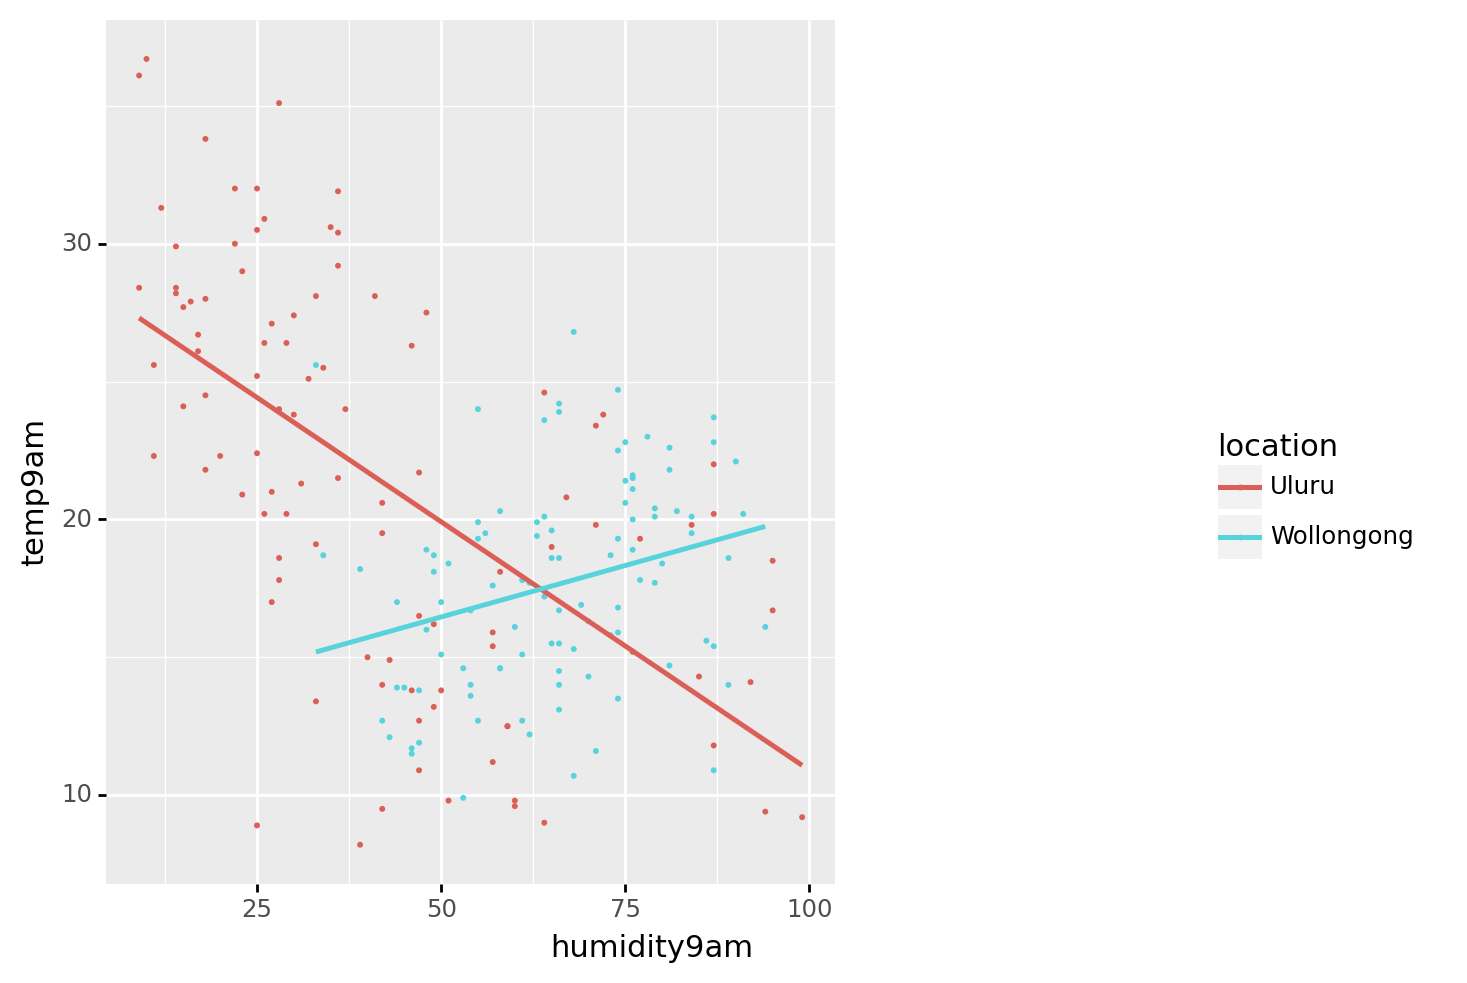

<ggplot: (428337062)>

<IPython.core.display.Javascript object>

In [45]:
(
    ggplot(weather_WU, aes(x="humidity9am", y="temp9am", color="location"))
    + geom_point(size=0.2)
    + geom_smooth(method="lm", se=False)
)

## 11.3.2 Simulating the posterior


In [46]:
model = bmb.Model("temp3pm ~ temp9am + location  + location:humidity9am", weather_WU)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp3pm_sigma, location:humidity9am, location, temp9am, Intercept]
INFO:pymc3:NUTS: [temp3pm_sigma, location:humidity9am, location, temp9am, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 26 seconds.


<IPython.core.display.Javascript object>

In [47]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,14.927,1.089,12.959,17.071,0.015,0.011,5160.0,4838.0,1.0
temp9am,0.784,0.034,0.716,0.843,0.000,0.000,5877.0,5785.0,1.0
location[Wollongong],-9.291,1.336,-11.870,-6.867,0.020,0.014,4561.0,4570.0,1.0
location:humidity9am[Uluru],-0.049,0.012,-0.071,-0.028,0.000,0.000,5613.0,5170.0,1.0
location:humidity9am[Wollongong],-0.001,0.017,-0.033,0.029,0.000,0.000,5373.0,4560.0,1.0
temp3pm_sigma,2.294,0.118,2.079,2.513,0.001,0.001,6522.0,4176.0,1.0


<IPython.core.display.Javascript object>

# 11.4 Dreaming bigger: Utilizing more than 2 predictors!


In [49]:
model = bmb.Model(
    "temp3pm ~ location + windspeed9am + humidity9am + pressure9am + temp9am",
    weather_WU,
)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=RANDOM_SEED)
posterior_predictive = model.predict(fitted, kind="pps", draws=500)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temp3pm_sigma, temp9am, pressure9am, humidity9am, windspeed9am, location, Intercept]
INFO:pymc3:NUTS: [temp3pm_sigma, temp9am, pressure9am, humidity9am, windspeed9am, location, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='temp3pm / temp3pm'>

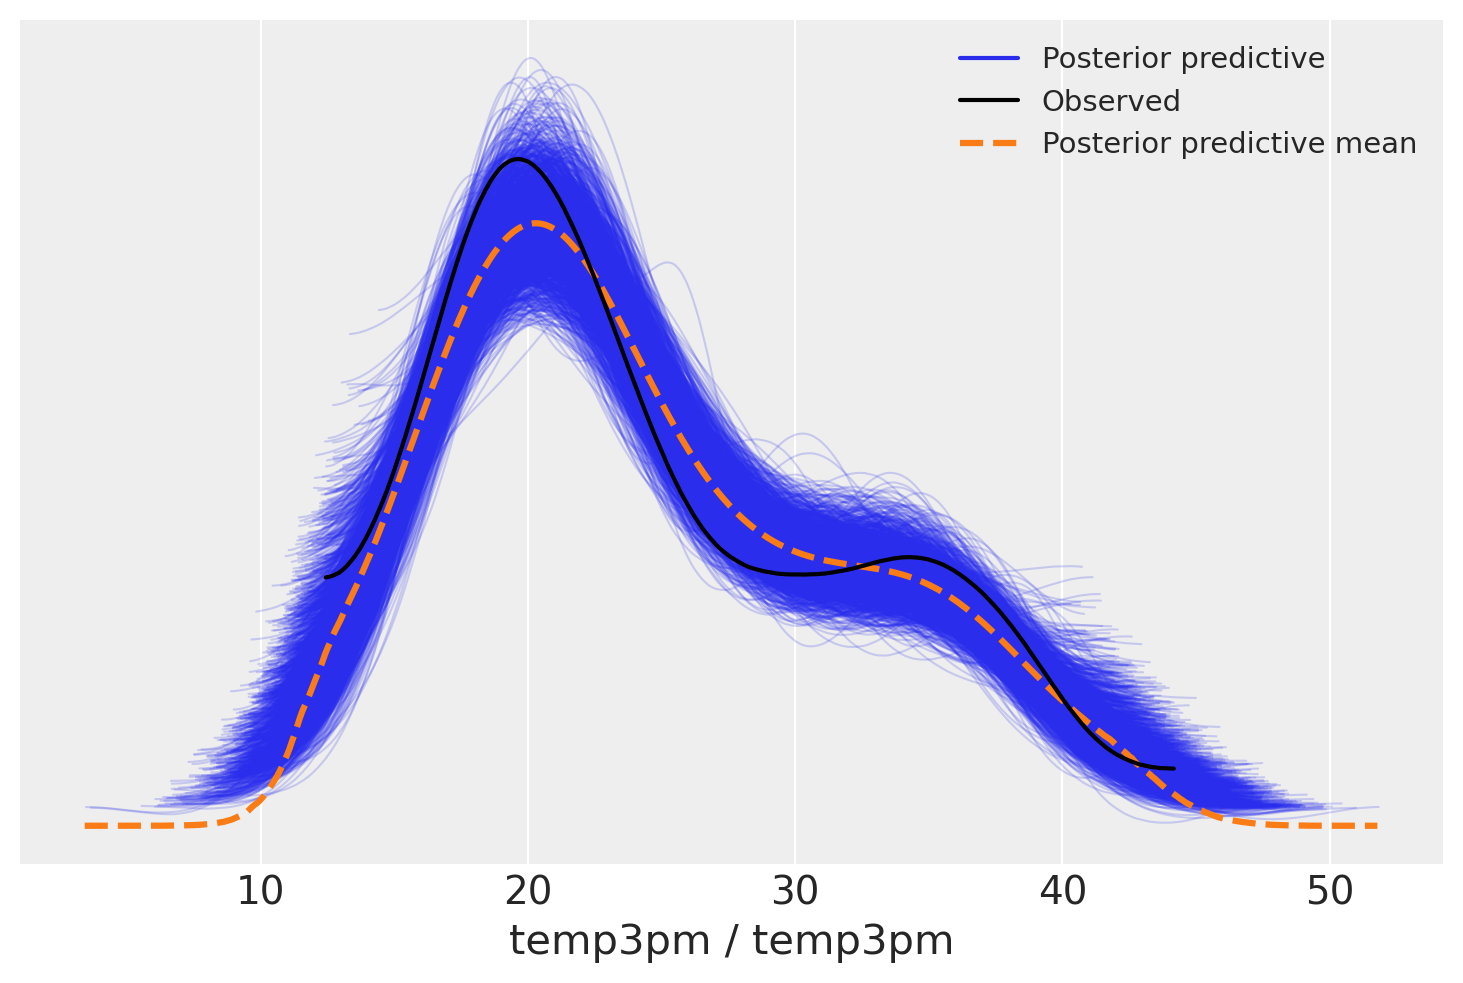

<IPython.core.display.Javascript object>

In [50]:
az.plot_ppc(fitted)

## 11.5.1 Evaluating predictive accuracy using visualizations